# #FelizMartes

En este proyecto vamos a ver cómo analizar un hashtag de Twitter. Aquí pongo transformaciones que se me han ocurrido, pero las posibilidades son infinitas.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unidecode as ud

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

### Vista general del hashtag

Previamente hemos descargado los tweets del hashtag en un archivo .txt con un programa llamado [t-hoarder](https://github.com/congosto/t-hoarder_kit).

Abrimos el archivo .txt con pandas para tenerla en formato dataframe). Cada línea es un tweet. Imprimimos los tweets recogidos.

In [2]:
ht = pd.read_csv('felizmartes_clean.txt', sep="\t", on_bad_lines="skip")
ht = ht.sort_values(by='date')
print('Hemos recolectado',len(ht),'tweets')
ht.head(2)

Hemos recolectado 12647 tweets


,id tweet,date,author,text,app,id user,followers,following,stauses,location,urls,geolocation,name,description,url_media,type media,quoted,relation,replied_id,user replied,retweeted_id,user retweeted,quoted_id,user quoted,first HT,lang,created_at,verified,avatar,link
12646,1567097639883407360,2022-09-06 10:29:27,@zoelaunik,"RT @chelorueda: “El AMOR, más que un te quiero, es un te cuido…” #Buenosdias☕️☕️ #Felizmartes #Seanfelices ♥️🤍 https://t.co/wl8esfmMdg",Twitter for Android,165663614,71,339,5210,recoleta,None,None,زوي,Sin pelos en la lengua!!! Twitter Original & Official® el 24/8 es mi cumpleaños,http://pbs.twimg.com/media/Fb872CiWIAMPh3k.jpg,photo,None,RT,None,None,1567037000045174785,@chelorueda,None,None,Buenosdias,es,2010-07-12 05:58:50,False,https://pbs.twimg.com/profile_images/863371856069447680/PV8A6_r1_normal.jpg,https://twitter.com/zoelaunik/status/1567097639883407360
12645,1567097677770260480,2022-09-06 10:29:36,@fl44444,RT @considerame: TTs [12:20] 🇪🇸 1⃣ #APOYOROCIO6S 2⃣ #FelizMartes 3⃣ #KrashxErik 4⃣ #MartianMTMAD14 5⃣ #ViolaComeIlMareVenezia79 🔝,Twitter for Android,1523320447865081856,95,43,8487,NaN,None,None,flo44,Sencill@ y natural😀,None,None,None,RT,None,None,1567095267077378051,@considerame,None,None,APOYOROCIO6S,und,2022-05-08 15:15:11,False,https://pbs.twimg.com/profile_images/1524793768154628098/v-XPpNWP_normal.jpg,https://twitter.com/fl44444/status/1567097677770260480


En Gephi, en la pestaña "Data laboratory", podemos exportar la información de las comunidades en un archivo .csv. Extraemos las columnas 'Label' (equivalente a author) y 'modularity_class' (comunidades) para añadirlas a nuestro dataframe principal. También cambiamos la columna 'Label' a 'author' para poderlas añadir más adelante. Para estandarizar nuestros datos, convertimos las columnas 'author', 'text' y 'user retweeted' minúsculas. Finalmente, unimos la columna 'modularity class' al dataframe, usando la columna 'author' como referencia.

In [3]:
ht_modularity = pd.read_csv('felizmartes_modularidad.csv')
ht_modularity = ht_modularity[['Label', 'modularity_class']]
ht_modularity.columns=['author', 'modularity_class']
ht_modularity['author'] = ht_modularity['author'].str.lower()
ht['author'] = ht['author'].str.lower()
ht['text'] = ht['text'].str.lower()
ht['user retweeted'] = ht['user retweeted'].str.lower()
ht = ht.merge(ht_modularity, how="left", on="author")
ht.head(2)

,id tweet,date,author,text,app,id user,followers,following,stauses,location,urls,geolocation,name,description,url_media,type media,quoted,relation,replied_id,user replied,retweeted_id,user retweeted,quoted_id,user quoted,first HT,lang,created_at,verified,avatar,link,modularity_class
0,1567097639883407360,2022-09-06 10:29:27,@zoelaunik,"rt @chelorueda: “el amor, más que un te quiero, es un te cuido…” #buenosdias☕️☕️ #felizmartes #seanfelices ♥️🤍 https://t.co/wl8esfmmdg",Twitter for Android,165663614,71,339,5210,recoleta,None,None,زوي,Sin pelos en la lengua!!! Twitter Original & Official® el 24/8 es mi cumpleaños,http://pbs.twimg.com/media/Fb872CiWIAMPh3k.jpg,photo,None,RT,None,None,1567037000045174785,@chelorueda,None,None,Buenosdias,es,2010-07-12 05:58:50,False,https://pbs.twimg.com/profile_images/863371856069447680/PV8A6_r1_normal.jpg,https://twitter.com/zoelaunik/status/1567097639883407360,24.0
1,1567097677770260480,2022-09-06 10:29:36,@fl44444,rt @considerame: tts [12:20] 🇪🇸 1⃣ #apoyorocio6s 2⃣ #felizmartes 3⃣ #krashxerik 4⃣ #martianmtmad14 5⃣ #violacomeilmarevenezia79 🔝,Twitter for Android,1523320447865081856,95,43,8487,NaN,None,None,flo44,Sencill@ y natural😀,None,None,None,RT,None,None,1567095267077378051,@considerame,None,None,APOYOROCIO6S,und,2022-05-08 15:15:11,False,https://pbs.twimg.com/profile_images/1524793768154628098/v-XPpNWP_normal.jpg,https://twitter.com/fl44444/status/1567097677770260480,0.0


A partir de la columna 'date' creamos otra con solo la fecha y la hora, sin minutos ni segundos.

In [4]:
ht['date_calc'] = ht['date'].apply(lambda x: x.split(":")[0])
ht['date_calc'] = ht['date_calc'].apply(lambda x: x + ":00")

Con esa nueva columna construimos una tabla dinámica para calcular cuántos tweets de cada clase hay por hora.

In [5]:
tweets_hour = pd.pivot_table(ht,index= "date_calc",columns= "modularity_class",aggfunc= ["count"],values=['id tweet'])
tweets_hour = tweets_hour.fillna(0)
tweets_hour.to_csv('distribucion_por_horas.csv')

tweets_hour = pd.read_csv('distribucion_por_horas.csv')
tweets_hour.columns = tweets_hour.iloc[1]
tweets_hour = tweets_hour[3:]
tweets_hour.to_csv('distribucion_por_horas.csv')

tweets_hour = pd.read_csv('distribucion_por_horas.csv')
tweets_hour = tweets_hour.drop(['Unnamed: 0'], axis=1)
tweets_hour.rename(columns={'modularity_class':'hour'}, inplace=True)
tweets_hour.head()

,hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
0,2022-09-06 10:00,106.0,16.0,57.0,26.0,2.0,1.0,4.0,4.0,0.0,41.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0,4.0,17.0,9.0,3.0,24.0,0.0,20.0,1.0,1.0,23.0,0.0,3.0,0.0,1.0,0.0,3.0,1.0,1.0
1,2022-09-06 11:00,327.0,132.0,55.0,44.0,8.0,8.0,8.0,0.0,0.0,38.0,3.0,3.0,1.0,2.0,1.0,46.0,0.0,8.0,13.0,27.0,1.0,20.0,25.0,28.0,58.0,0.0,39.0,65.0,2.0,10.0,2.0,2.0,0.0,1.0,0.0,11.0
2,2022-09-06 12:00,547.0,112.0,85.0,40.0,25.0,16.0,18.0,2.0,0.0,19.0,0.0,8.0,2.0,20.0,37.0,45.0,0.0,5.0,6.0,27.0,0.0,6.0,31.0,17.0,62.0,15.0,57.0,13.0,6.0,13.0,3.0,20.0,13.0,2.0,0.0,7.0
3,2022-09-06 13:00,498.0,58.0,96.0,83.0,25.0,30.0,44.0,58.0,0.0,4.0,0.0,0.0,0.0,23.0,7.0,44.0,0.0,5.0,5.0,14.0,1.0,11.0,26.0,57.0,47.0,8.0,55.0,7.0,3.0,5.0,1.0,6.0,0.0,1.0,0.0,4.0
4,2022-09-06 14:00,310.0,19.0,93.0,43.0,15.0,24.0,30.0,32.0,1.0,41.0,2.0,1.0,11.0,3.0,9.0,46.0,4.0,1.0,1.0,4.0,21.0,7.0,29.0,27.0,65.0,18.0,25.0,12.0,1.0,2.0,6.0,2.0,1.0,4.0,0.0,9.0


Representamos el número de tweets por hora en un gráfico de barras acumuladas para identificar diferentes picos de actividad y la importancia de las diferentes comunidades. 

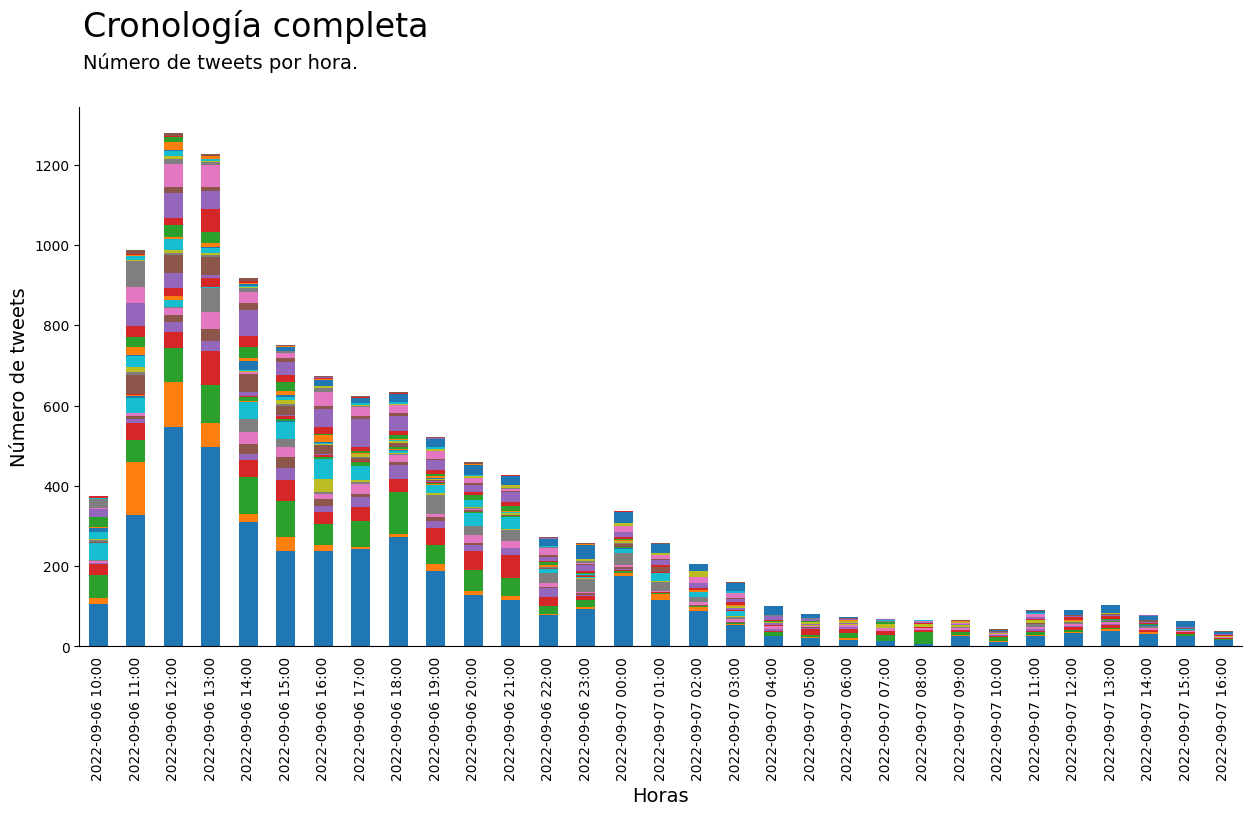

In [6]:
ax = tweets_hour.plot.bar(x='hour', stacked=True,figsize=(15,7),legend=None)
ax.spines[['top','right']].set_visible(False)
plt.text(-0.4,1520,'Cronología completa',fontsize=24)
plt.text(-0.4,1440,'Número de tweets por hora.',fontsize=14)
plt.xlabel('Horas',fontsize=14)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=True)
plt.ylabel('Número de tweets',fontsize=14)
plt.savefig('1. cronologia completa.jpg',bbox_inches='tight',dpi=50)

Podemos filtrar por fecha y quedarnos solo con el martes 6.

In [7]:
viz_peak = tweets_hour[(tweets_hour['hour'] > "2022-09-06 00:00")&(tweets_hour['hour'] < "2022-09-07 00:00")]
viz_peak.head(5)

,hour,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
0,2022-09-06 10:00,106.0,16.0,57.0,26.0,2.0,1.0,4.0,4.0,0.0,41.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0,4.0,17.0,9.0,3.0,24.0,0.0,20.0,1.0,1.0,23.0,0.0,3.0,0.0,1.0,0.0,3.0,1.0,1.0
1,2022-09-06 11:00,327.0,132.0,55.0,44.0,8.0,8.0,8.0,0.0,0.0,38.0,3.0,3.0,1.0,2.0,1.0,46.0,0.0,8.0,13.0,27.0,1.0,20.0,25.0,28.0,58.0,0.0,39.0,65.0,2.0,10.0,2.0,2.0,0.0,1.0,0.0,11.0
2,2022-09-06 12:00,547.0,112.0,85.0,40.0,25.0,16.0,18.0,2.0,0.0,19.0,0.0,8.0,2.0,20.0,37.0,45.0,0.0,5.0,6.0,27.0,0.0,6.0,31.0,17.0,62.0,15.0,57.0,13.0,6.0,13.0,3.0,20.0,13.0,2.0,0.0,7.0
3,2022-09-06 13:00,498.0,58.0,96.0,83.0,25.0,30.0,44.0,58.0,0.0,4.0,0.0,0.0,0.0,23.0,7.0,44.0,0.0,5.0,5.0,14.0,1.0,11.0,26.0,57.0,47.0,8.0,55.0,7.0,3.0,5.0,1.0,6.0,0.0,1.0,0.0,4.0
4,2022-09-06 14:00,310.0,19.0,93.0,43.0,15.0,24.0,30.0,32.0,1.0,41.0,2.0,1.0,11.0,3.0,9.0,46.0,4.0,1.0,1.0,4.0,21.0,7.0,29.0,27.0,65.0,18.0,25.0,12.0,1.0,2.0,6.0,2.0,1.0,4.0,0.0,9.0


Podemos quitar comunidades y renombrar las columnas para crear un gráfico de barras con leyenda.

In [8]:
viz_peak = viz_peak.drop(['4.0','5.0','6.0'], axis=1)
viz_peak = viz_peak.rename(columns={'0.0': 'comunidad_x', '1.0': 'comunidad_y'})

In [9]:
viz_peak.head()

,hour,comunidad_x,comunidad_y,2.0,3.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
0,2022-09-06 10:00,106.0,16.0,57.0,26.0,4.0,0.0,41.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0,4.0,17.0,9.0,3.0,24.0,0.0,20.0,1.0,1.0,23.0,0.0,3.0,0.0,1.0,0.0,3.0,1.0,1.0
1,2022-09-06 11:00,327.0,132.0,55.0,44.0,0.0,0.0,38.0,3.0,3.0,1.0,2.0,1.0,46.0,0.0,8.0,13.0,27.0,1.0,20.0,25.0,28.0,58.0,0.0,39.0,65.0,2.0,10.0,2.0,2.0,0.0,1.0,0.0,11.0
2,2022-09-06 12:00,547.0,112.0,85.0,40.0,2.0,0.0,19.0,0.0,8.0,2.0,20.0,37.0,45.0,0.0,5.0,6.0,27.0,0.0,6.0,31.0,17.0,62.0,15.0,57.0,13.0,6.0,13.0,3.0,20.0,13.0,2.0,0.0,7.0
3,2022-09-06 13:00,498.0,58.0,96.0,83.0,58.0,0.0,4.0,0.0,0.0,0.0,23.0,7.0,44.0,0.0,5.0,5.0,14.0,1.0,11.0,26.0,57.0,47.0,8.0,55.0,7.0,3.0,5.0,1.0,6.0,0.0,1.0,0.0,4.0
4,2022-09-06 14:00,310.0,19.0,93.0,43.0,32.0,1.0,41.0,2.0,1.0,11.0,3.0,9.0,46.0,4.0,1.0,1.0,4.0,21.0,7.0,29.0,27.0,65.0,18.0,25.0,12.0,1.0,2.0,6.0,2.0,1.0,4.0,0.0,9.0


Representamos el pico. La leyenda es muy grande porque hay muchas comunidades, pero se podría ocultar. Las líneas que empiezan con # no se ejecutan.

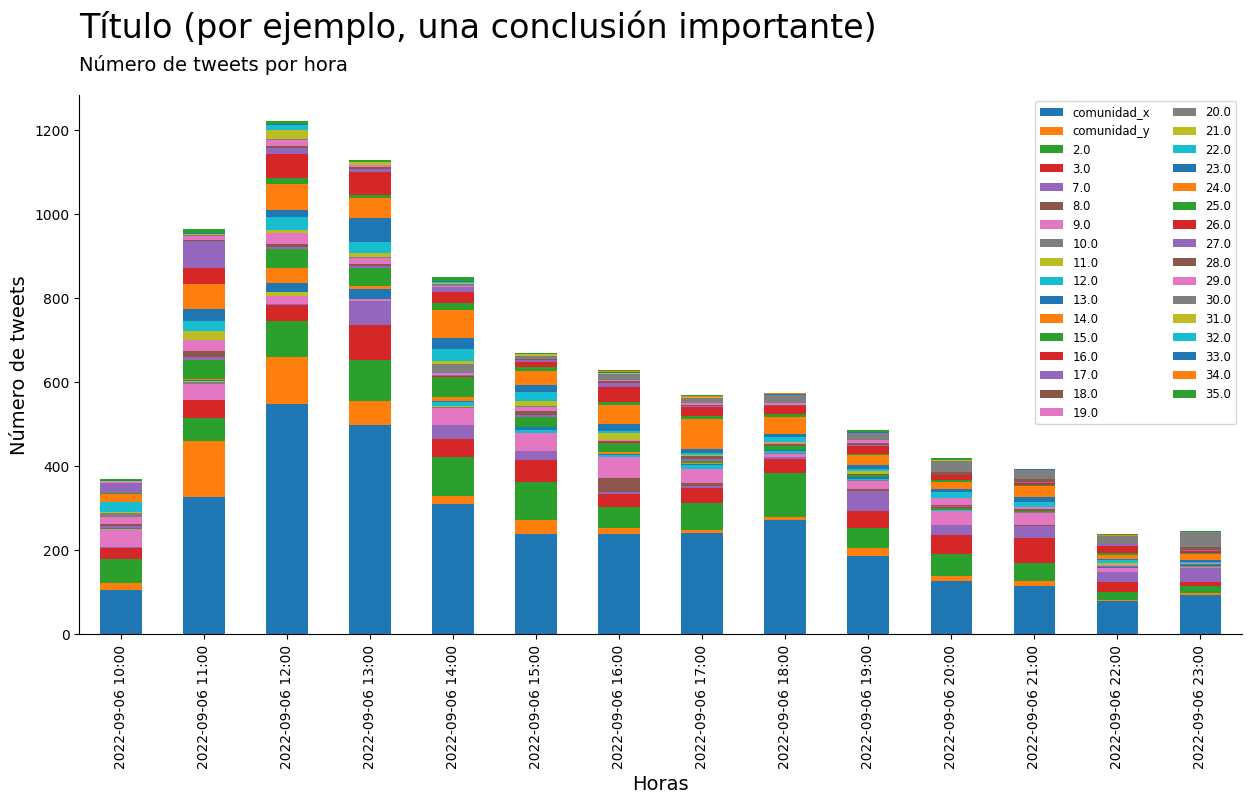

In [10]:
ax = viz_peak.plot.bar(x='hour', stacked=True,figsize=(15,7))
ax.spines[['top','right']].set_visible(False)
plt.xticks(rotation=90,ha='center')
plt.legend(loc='upper right', ncol=2, fontsize = 'small')
#plt.text tiene coordenadas x e y. Según el tamaño del gráfico habrá que cambiarlas para situar bien el título y el subtítulo.
plt.text(-0.5,1420,'Título (por ejemplo, una conclusión importante)',fontsize=24)
plt.text(-0.5,1340,'Número de tweets por hora',fontsize=14)
plt.xlabel('Horas', fontsize=14)
plt.tick_params(axis='x',which='both',bottom=True,top=False,labelbottom=True)
plt.ylabel('Número de tweets',fontsize=14)
plt.savefig('2. pico por horas.jpg',bbox_inches='tight',dpi=50)

Esta vez transformamos el tiempo en fecha, horas y minutos.

In [11]:
ht_minutes = ht
ht_minutes['date_calc'] = ht_minutes['date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
ht_minutes['date_calc'] = ht_minutes['date_calc'].apply(lambda x:x.strftime('%Y-%m-%d %H:%M'))

Creamos otra tabla dinámica de la misma forma.

In [12]:
tweets_minutes = pd.pivot_table(ht_minutes,index= "date_calc",columns= "modularity_class",aggfunc= ["count"],values=['id tweet'])
tweets_minutes = tweets_minutes.fillna(0)
tweets_minutes.to_csv('distribucion_por_minutos.csv')

tweets_minutes = pd.read_csv('distribucion_por_minutos.csv')
tweets_minutes.columns = tweets_minutes.iloc[1]
tweets_minutes = tweets_minutes[3:]
tweets_minutes.to_csv('distribucion_por_minutos.csv')

tweets_minutes = pd.read_csv('distribucion_por_minutos.csv')
tweets_minutes = tweets_minutes.drop(['Unnamed: 0'], axis=1)
tweets_minutes.rename(columns={'modularity_class':'minute'}, inplace=True)
tweets_minutes.head()

,minute,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0
0,2022-09-06 10:29,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2022-09-06 10:30,7.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-09-06 10:31,5.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-09-06 10:32,5.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-09-06 10:33,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hacemos zoom a una hora cualquiera.

In [13]:
start_hashtag = tweets_minutes[(tweets_minutes['minute'] > "2022-09-06 12:00")&(tweets_minutes['minute'] < "2022-09-06 13:00")]

Descartamos las mismas clases y aplicamos los mismos nombres a las columnas como hicimos previamente, aunque podríamos cambiarlo a nuestro gusto en cada paso.

In [14]:
start_hashtag = start_hashtag.drop(['4.0','5.0','6.0'], axis=1)
start_hashtag = start_hashtag.rename(columns={'0.0': 'comunidad_x', '1.0': 'comunidad_y'})

Representamos de nuevo.

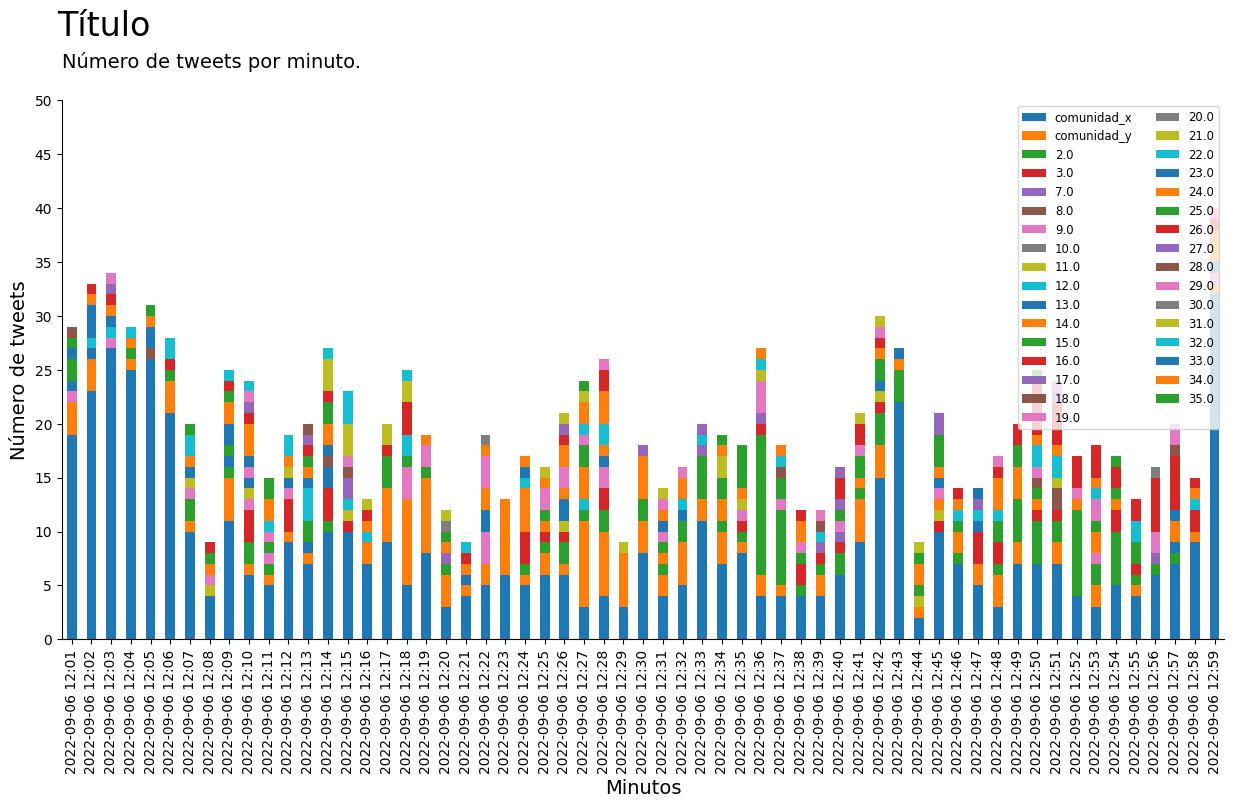

In [15]:
ax = start_hashtag.plot.bar(x='minute', stacked=True, figsize=(15,7))
ax.spines[['top','right']].set_visible(False)
plt.xticks(rotation=90)
plt.yticks(np.arange(0,55,5.0))
plt.text(-0.75,56,'Título',fontsize=24)
plt.text(-0.5,53,'Número de tweets por minuto.',fontsize=14)
plt.legend(loc='upper right', ncol=2, fontsize = 'small')
plt.xlabel('Minutos',fontsize=14)
plt.ylabel('Número de tweets',fontsize=14)
plt.savefig('3. pico por minutos.jpg',bbox_inches='tight',dpi=100)

### Primeros 5 tweets

Si tuvieramos un inicio claro de actividad, por ejemplo si fuera un hashtag programado, podríamos ver los primeros 5 tweets recogidos de esta manera. Imaginemos que la actividad explota a las 14:00h.

In [16]:
primeros_5_tweets = ht[ht['date'] > '2022-11-07 14:00'].head()
primeros_5_tweets[['id tweet','date','author','text']]

,id tweet,date,author,text


Nos podríamos con ciertas comunidades. Esta línea de código sirve para filtrar aquellas líneas cuya modularidad coincida con los valores que queremos. Como tiene # delante no se va a ejecutar.

In [17]:
#ht = ht[ht['modularity_class'].isin([6.0,7.0,9.0,5.0])].reset_index(inplace=False)
#ht = ht.drop(['index'], axis=1)

También podemos filtrar el dataframe original por fecha.

In [18]:
ht_pico = ht[(ht['date'] > "2022-09-06 00:00")&(ht['date'] < "2022-09-07 00:00")]

In [19]:
print('El pico tiene',len(ht_pico),'tweets')

El pico tiene 10653 tweets


Una vez hemos limpiado los datos los exportamos a un archivo .txt que usaremos en un futuro.

In [20]:
ht_pico.to_csv('felizmartes_pico.txt',sep='\t',index=False)

### Número de usuarios 

In [21]:
print(len(ht_pico['author'].unique()),'usuarios fueron responsables del pico.')

7032 usuarios fueron responsables del pico.


### A quién se menciona más

Vamos a obtener las menciones. Creamos una función que busque en la columna 'text' las palabras que empiezan por @.

In [22]:
def extraer_mentions(row):
    texto = row['text']
    mentions = re.findall(r"@(\w+)", texto)
    findall_mentions.append(mentions)

Aplicamos la función y obtenemos una lista de lista. Aplicamos un loop para separar los hashtags de uno en uno, quitar las tildes y poner en minúsculas los hashtags.

In [23]:
findall_mentions = []

ht_pico.apply(extraer_mentions,axis=1)
lista_mentions = []
for lista in findall_mentions:
    for mention in lista:
        mention = ud.unidecode(mention)
        mention = mention.lower()
        lista_mentions.append(mention)


Convertimos la lista de hashtags a dataframe.

In [24]:
lista_mentions_series = pd.Series(lista_mentions)
mentions_count = lista_mentions_series.value_counts().head(20)
mentions_count = mentions_count.reset_index()
mentions_count.columns = ['user','mentions']

In [25]:
mentions_count

,user,mentions
0,miercolesrepubl,726
1,jjaranaz94,542
2,traselvalle_obc,535
3,lonspe1,461
4,dezurdateam_,412
5,inameh,307
6,luismerlo_actor,210
7,diarioveahoy,208
8,egmorenor,163
9,arteviajero_com,156


Contamos los retweets recibidos para limpiar los datos ya que para twitter un retweet se traduce como "rt @" y también se contabiliza como mención. Después los restaremos al número de menciones

In [26]:
rts = ht_pico['user retweeted'].value_counts()

Pasamos la serie a DataFrame.

In [27]:
rts = rts.to_frame().reset_index()
rts.columns = ['user','rts_received']

In [28]:
rts['user'] = rts['user'].apply(lambda x:x.replace('@',''))

Juntamos las menciones y los retweets recibidos asegurándonos que cada número de menciones corresponde a su usuario.

In [29]:
mentions_merged = mentions_count.merge(rts,how='left',on='user')

A los que no tenga retweets porque no han participado en el hashtag o no han recibido ninguno les ponemos un 0.

In [30]:
mentions_merged['rts_received'] = mentions_merged['rts_received'].fillna(0)

Restamos los retweets recibidos a las menciones.

In [31]:
mentions_merged['mentions'] = mentions_merged['mentions'] - mentions_merged['rts_received']

Representamos el top 5 con un gráfico de barras horizontales. Este gráfico de barras nos indica que ha habido mucho spam hacia ciertas cuentas.

A partir de esta parte lo más complicado va a ser entender las coordenadas. Según los valores de cada gráfico serán unas u otras.

Ejemplo: plt.txt(0,22) <- estas son las coordenadas x(0) e y(22). Quiere decir que el texto se colocará en el cero del eje y y en el 22 del eje x. Elijo 22 porque al haber 20 barras la posición de título queda bien en la 22, ya que tiene que ser más alto.

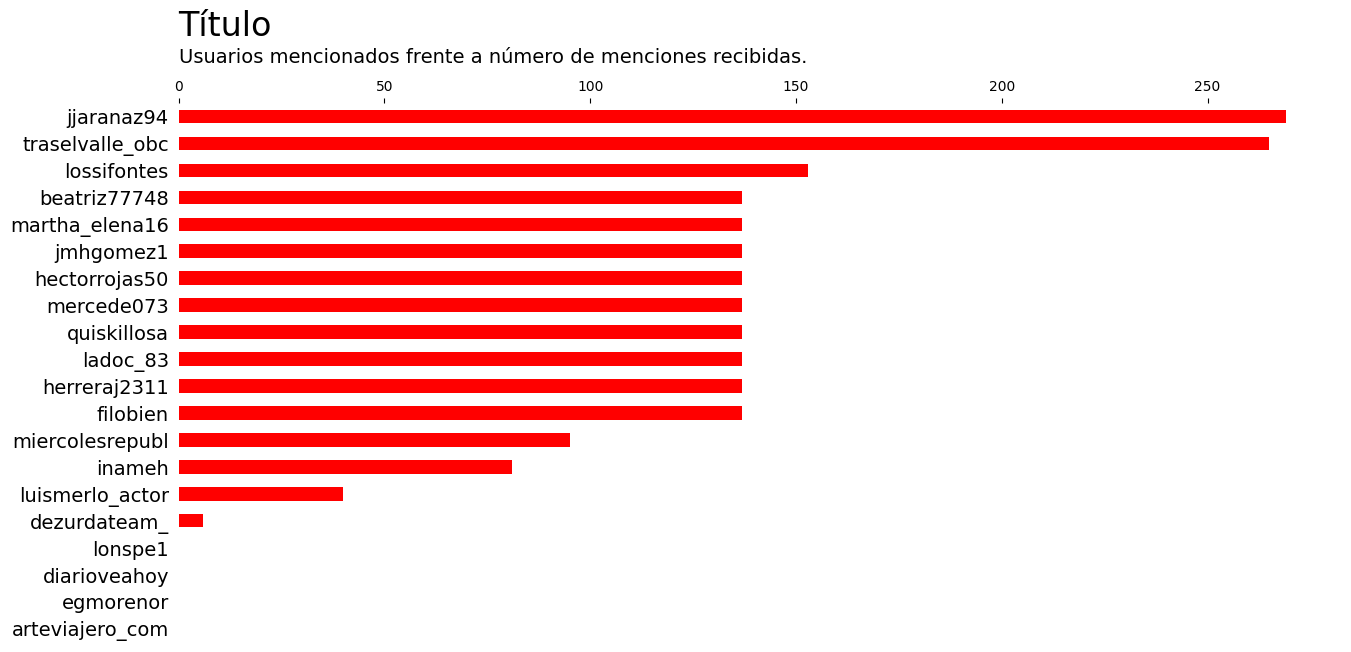

In [32]:
mentions = mentions_merged.sort_values(by='mentions',ascending=True).tail(20)

ax = mentions.plot.barh(x='user',y='mentions',figsize=(15,7),color='red',label='',legend=None,fontsize=14)
ax.spines[['top','bottom','left','right']].set_visible(False)
plt.tick_params(axis='x',which='both',bottom=False,top=True,labelbottom=False,labeltop=True)
plt.tick_params(axis='y',which='both',left=False,right=False)
plt.xlabel('',fontsize=14)
plt.ylabel('')
plt.text(0,22,'Título',fontsize=24)
plt.text(0,21,'Usuarios mencionados frente a número de menciones recibidas.',fontsize=14)
plt.savefig('5. menciones.jpg',bbox_inches='tight',dpi=50)

### Hashtags secundarios más usados

Repetimos el mismo proceso de obtención con los hashtags.

In [33]:
def extraer_hashtags(row):
    texto = row['text']
    hashtags = re.findall(r"#(\w+)", texto)
    findall_hashtags.append(hashtags)

In [34]:
findall_hashtags = []

ht_pico.apply(extraer_hashtags,axis=1)

None #para que no salga ningún resultado en la celda

In [35]:
lista_hashtags = []
for lista in findall_hashtags:
    for hashtag in lista:
        hashtag = ud.unidecode(hashtag)
        hashtag = hashtag.lower()
        lista_hashtags.append(hashtag)

In [36]:
lista_hashtags_series = pd.Series(lista_hashtags)

In [37]:
hashtag_count = lista_hashtags_series.value_counts().head(20)
hashtag_count = hashtag_count.reset_index()
hashtag_count.columns = ['hashtag','count']

Quitamos el primero porque es el hashtag de estudio, queremos visualizar los secundarios.

In [38]:
ht_secundarios = hashtag_count.drop(0)

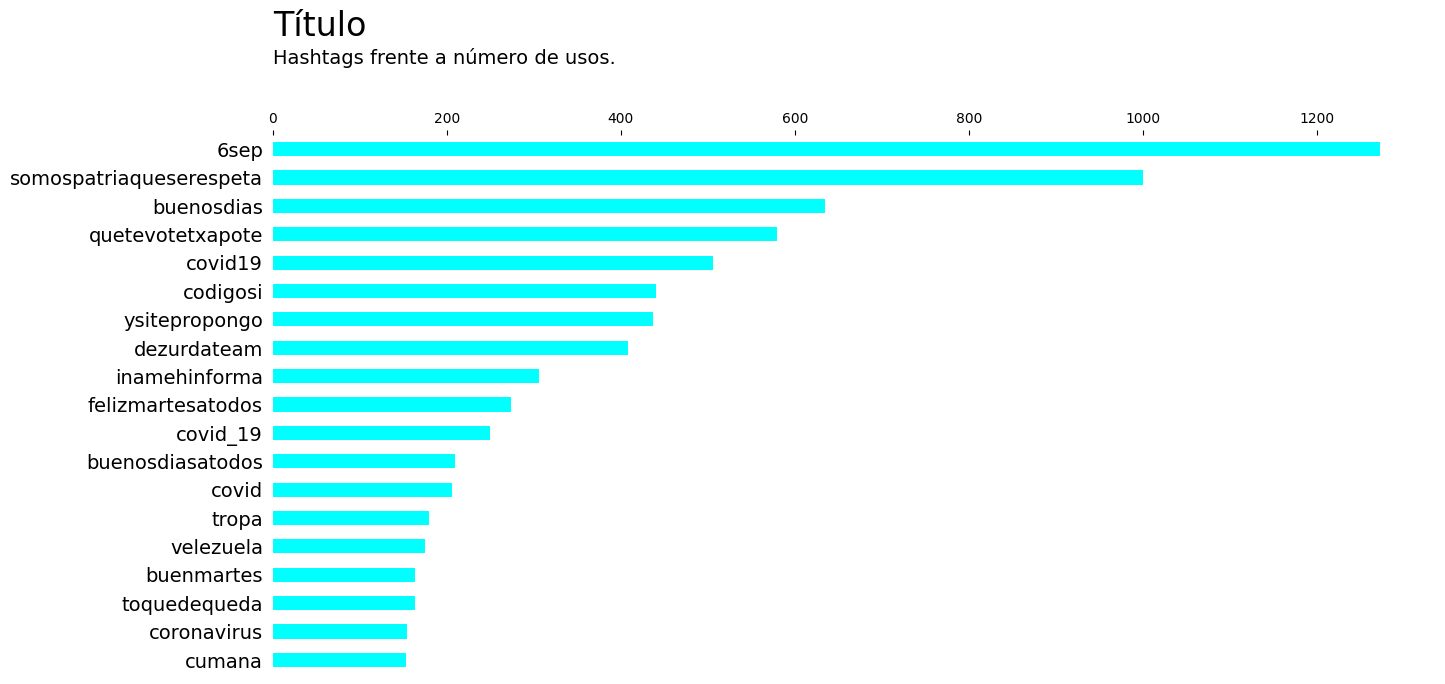

In [39]:
ht_secundarios = ht_secundarios.sort_values(by='count',ascending=True)
ax = ht_secundarios.plot.barh(x='hashtag',y='count',figsize=(15,7),color='cyan',label='',legend=None,fontsize=14)
ax.spines[['top','bottom','left','right']].set_visible(False)
plt.tick_params(axis='x',which='both',bottom=False,top=True,labelbottom=False,labeltop=True)
plt.tick_params(axis='y',which='both',left=False,right=False)
plt.xlabel('',fontsize=14)
plt.ylabel('')
plt.text(0,22,'Título',fontsize=24)
plt.text(0,21,'Hashtags frente a número de usos.',fontsize=14)
plt.savefig('5.1 hashtags secundarios.jpg',bbox_inches='tight',dpi=50)

### Tweets más retweeteados

Contamos los tweets más retweeteados y los guardamos como dataframe para hacerlos más fáciles de leer.

In [40]:
mas_retweeteados = ht_pico['text'].value_counts().to_frame().reset_index()
mas_retweeteados.columns = ['text','count']
mas_retweeteados

,text,count
0,"rt @lonspe1: ¡¡ éxito absoluto de antonio sánchez en su encuentro con la ciudadanía...!! 😂😂, que te vote txapote #quetevotetxapote 🤬 #felizmartes camboya birmania https://t.co/oz9oozytib",461
1,"rt @dezurdateam_: #felizmartes familia. la diversidad familiar que coexiste en la sociedad cubana actual determina la necesidad de un nuevo código de las familias, un código donde quepan todas las familias. #ysitepropongo decir #códigosí. yo votó sí. ¿y tú? #dezurdateam🤝 https://t.co/glt1ycoclc",405
2,"rt @miercolesrepubl: ninguna de las monarquías europeas fueron implantadas por un fascista dictador, el pueblo español en 1931 votó para echar a la monarquía y a los borbones. franco nos la devolvió, la constitución del 78 es fruto del miedo y del engaño, #felizmartes https://t.co/pylnghkuel",295
3,"rt @luismerlo_actor: no siempre se recibe lo que se da como se suele decir. pero lo que das representa lo que eres, y eso es lo que realmente importa. #buenosdías #felizmartes",168
4,rt @reginaorozco: ¿qué título le pondrías a esta foto? 🥭🍌🍊🍉 #vivaméxico #felizmartes https://t.co/3viykvbiyp,137
...,...,...
4342,actos de bondad desde el corazón de @amazonmex ❤️🤗 ¡no te lo pierdas!📲 https://t.co/ofdbyreyro #empresastrabajandoxti #felizmartes https://t.co/8qc2uy8hzq,1
4343,top 10 tendencias de twitter en méxico: #seguimosdandoresultados: 102221 #felizmartes: none #kornoldiebutgoodie: none #5toinformeedomex: 88428 #caminitoalaescuela: none waze: none chile: 674621 chris pine: 173224 secretaria de educación: 54109 leticia ramírez: 36978,1
4344,✅ feliz día 💪 #emprendedores #felizmartes https://t.co/kdpuucjxmk,1
4345,"#felizmartes 😄 hoy es otro día, otro sol, otra sonrisa, otra oportunidad, una nueva esperanza; #nuncaestarde para cumplir tus metas y objetivos educativos. 📞 (223) 751332 ¡concluye con nosotros primaria o secundaria! 🤩 totalmente gratuito y con validez oficial. https://t.co/cafvthythc",1


# Calcular volúmenes de autores

Creamos la base de nuestro dataframe de volumen con los usuarios únicos.

In [ ]:
volumen = ht_pico['author'].to_frame()
volumen = volumen.drop_duplicates(subset='author')
volumen = volumen.reset_index().drop('index',axis=1)
volumen.head()

,author
0,jramiromx
1,egmorenor
2,mpineda1970
3,capegreco
4,twdepatria


Calculamos la cantidad de aportaciones totales, retweets, tweets originales y retweets recibidos. Dejo los totales como ejemplo.

In [ ]:
total = ht_pico['author'].value_counts().reset_index()
total.columns = ['author','total']
total.head()

,author,total
0,traselvalle_obc,453
1,importyexport,76
2,jjaranaz94,44
3,elhoroscopodel1,40
4,tesoromoctezuma,28


In [ ]:
ht_pico_rt = ht_pico[ht_pico['relation'] == 'retweeted']

retweets_hechos = ht_pico_rt['author'].value_counts().reset_index()
retweets_hechos.columns = ['author','retweets realizados']


In [ ]:
ht_pico_original = ht_pico[ht_pico['relation'] != 'retweeted']

originales = ht_pico_original['author'].value_counts().reset_index()
originales.columns = ['author','tweets originales']

In [ ]:
retweets_recibidos = ht['user retweeted'].value_counts().to_frame().reset_index()
retweets_recibidos.columns = ['author','retweets recibidos']

Unimos cada conteo con el dataframe de volumen.

In [ ]:
volumen = volumen.merge(total,on='author',how='left')
volumen = volumen.merge(retweets_hechos,on='author',how='left')
volumen = volumen.merge(originales,on='author',how='left')
volumen = volumen.merge(retweets_recibidos,on='author',how='left')

Quitamos los valores NaN y los pasamos a integer (int)

In [ ]:
volumen = volumen.fillna(0)
volumen['retweets realizados'] = volumen['retweets realizados'].apply(lambda x:int(x))
volumen['tweets originales'] = volumen['tweets originales'].apply(lambda x:int(x))
volumen['retweets recibidos'] = volumen['retweets recibidos'].apply(lambda x:int(x))
volumen.head(5)

,author,total,retweets realizados,tweets originales,retweets recibidos
0,jramiromx,6,0,6,42
1,egmorenor,26,0,26,447
2,mpineda1970,1,1,0,0
3,capegreco,1,1,0,0
4,twdepatria,1,1,0,0


### Tweets originales

Es probable que se copien tweets en vez de hacer retweet y esos no los vamos a contar como tweets originales. Vamos a comprobarlo.

Primero quitamos los retweets.

In [45]:
ht_copypaste = ht_pico[~ht_pico['text'].str.startswith("rt @")]

Quitamos los enlaces del final porque hacen a los tweets diferentes para la API de Twitter, pero en la interfaz de usuario son iguales.

In [46]:
ht_copypaste['text'] = ht_copypaste['text'].apply(lambda x:re.sub(r'http\S+', '', x))

Descartamos los duplicados manteniendo los primeros, que serán de los autores originales porque están ordenados por fecha.

In [47]:
ht_copypaste = ht_copypaste.drop_duplicates(subset='text',keep='first')

Sacamos la serie de autores y tweets verdaderamente originales y la transformamos en dataframe.

In [48]:
true_original_tweets = ht_copypaste['author'].value_counts()
true_original_tweets = true_original_tweets.to_frame().reset_index()
true_original_tweets.columns = ['author','true_original_tweets']

Unimos la columna a la tabla de volumen.

In [49]:
volume = volume.merge(true_original_tweets,how='left',on='author')
volume['true_original_tweets'] = volume['true_original_tweets'].fillna(0)
volume['true_original_tweets'] = volume['true_original_tweets'].apply(lambda x:int(x))
volume = volume[['author','total','original_tweets','true_original_tweets','rts_made','rts_received']]


Contamos los falsos y se los restamos a los originales.

In [50]:
fake_original_count = volume['original_tweets'].sum()
true_original_count = volume['true_original_tweets'].sum()
print(fake_original_count,'-',true_original_count)

2875 - 2617


In [51]:
copied_tweets = volume['original_tweets'].sum() - volume['true_original_tweets'].sum()
print(copied_tweets,'tweets fueron copiados.')

258 tweets fueron copiados.


### Gráficos

En esta parte vamos a contar los tweets originales, las aportaciones totales y los retweets hechos y recibidos del top 5 de cada medida. También averiguaremos qué porcentaje supone del total. Por último vamos a calcular la media de todos los usuarios. Una vez que lo tengamos todo lo vamos a representar en cuatro gráficos.

In [52]:
true_original_top20 = volume.sort_values(by='true_original_tweets',ascending=False).head(20)
true_original_top20.head()

,author,total,original_tweets,true_original_tweets,rts_made,rts_received
19,@elhoroscopodel1,106,106,106,0,8
988,@benavidesang,90,90,90,0,8
782,@jeps2009,41,41,41,0,3
3009,@diarioveahoy,46,46,40,0,255
1595,@jramiromx,132,68,32,64,77


In [53]:
true_original_top20_count = true_original_top20['true_original_tweets'].sum()
true_original_top20_count

571

In [54]:
true_original_top20_percentage = (true_original_top20_count/volume['true_original_tweets'].sum()*100).round(1)
true_original_top20_percentage

21.8

In [55]:
true_original_mean = round((true_original_count/authors_unique),1)
true_original_mean

0.4

In [56]:
true_original_top20 = volume.sort_values(by=['true_original_tweets'],ascending=False).head(20)

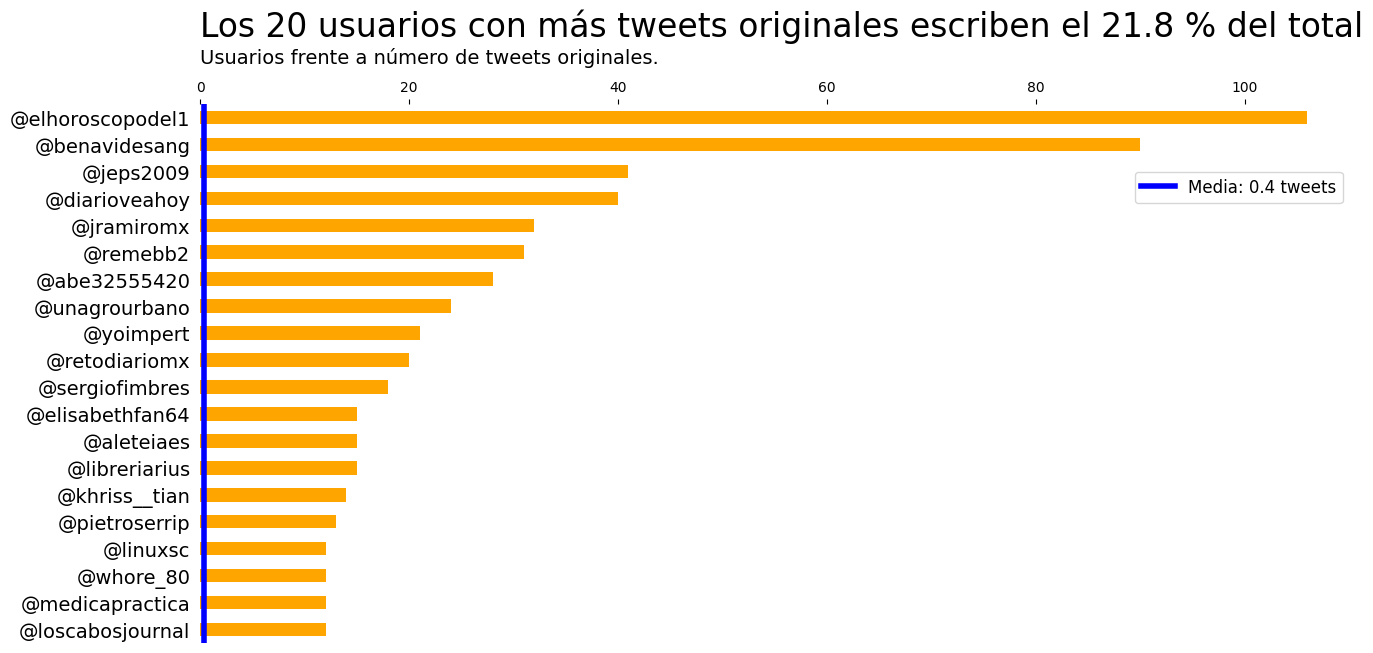

In [57]:
true_original_top20_sorted = volume.sort_values(by=['true_original_tweets'],ascending=True).tail(20)

ax = true_original_top20_sorted.plot.barh(x='author',y='true_original_tweets',figsize=(15,7),color='orange',label='',fontsize=14)
ax.spines[['top','bottom','left','right']].set_visible(False)
plt.tick_params(axis='x',which='both',bottom=False,top=True,labelbottom=False,labeltop=True)
plt.tick_params(axis='y',which='both',left=False,right=False)
plt.xlabel('',fontsize=14)
plt.ylabel('')
plt.text(0,22,'Los 20 usuarios con más tweets originales escriben el {} % del total'.format(true_original_top20_percentage),
         fontsize=23.8)
plt.text(0,21,'Usuarios frente a número de tweets originales.',fontsize=14)
plt.axvline(x=true_original_mean,color='blue',linewidth=4,label='Media: {} tweets'.format(true_original_mean))
plt.legend(bbox_to_anchor=(0.99,0.89),prop={'size': 12})
plt.savefig('6.1. originales.jpg',bbox_inches='tight',dpi=50)

### Aportaciones (tweets + RTs)

In [58]:
aportaciones_top20 = volume.sort_values(by=['total'],ascending=False).head(20)
aportaciones_top20.head()

,author,total,original_tweets,true_original_tweets,rts_made,rts_received
557,@traselvalle_obc,404,3,3,401,276
2162,@jjaranaz94,157,0,0,157,282
1595,@jramiromx,132,68,32,64,77
19,@elhoroscopodel1,106,106,106,0,8
988,@benavidesang,90,90,90,0,8


In [59]:
# Hacer int si acaba en ".0" para dejar un número redondo.
porcentaje_aportaciones_top20 = int((aportaciones_top20['total'].sum()/volume['total'].sum()*100).round(1))
porcentaje_aportaciones_top20

11

In [60]:
mean_aportaciones = round(volume['total'].mean(),1)
mean_aportaciones 

1.6

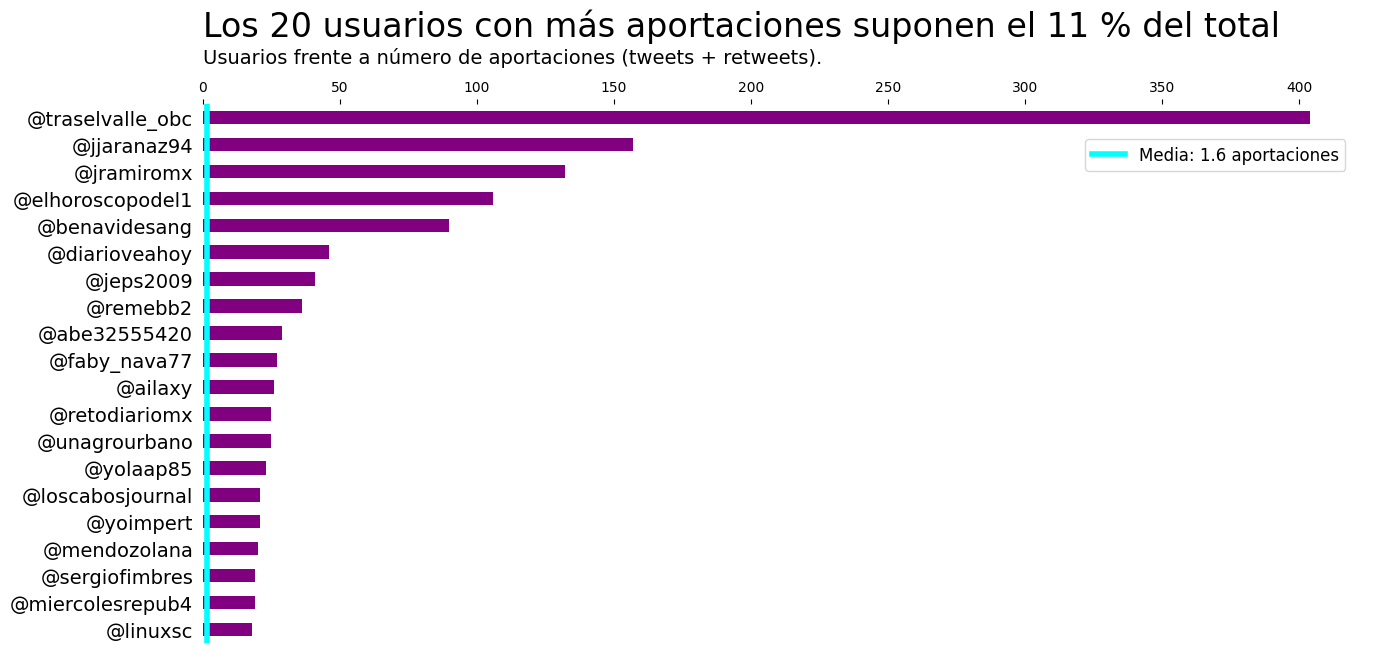

In [61]:
aportaciones_top20_sorted = volume.sort_values(by=['total'],ascending=True).tail(20)

ax = aportaciones_top20_sorted.plot.barh(x='author',y='total',figsize=(15,7),color='purple',label='',fontsize=14)
ax.spines[['top','bottom','left','right']].set_visible(False)
plt.tick_params(axis='x',which='both',bottom=False,top=True,labelbottom=False,labeltop=True)
plt.tick_params(axis='y',which='both',left=False,right=False)
plt.xlabel('',fontsize=14)
plt.ylabel('')
plt.text(0,22,'Los 20 usuarios con más aportaciones suponen el {} % del total'.format(porcentaje_aportaciones_top20),
         fontsize=24)
plt.text(0,21,'Usuarios frente a número de aportaciones (tweets + retweets).',fontsize=14)
plt.axvline(x=mean_aportaciones,color='cyan',linewidth=4,label='Media: {} aportaciones'.format(mean_aportaciones))
plt.legend(bbox_to_anchor=(0.99,0.95),prop={'size': 12})
plt.savefig('6.2 aportaciones.jpg',bbox_inches='tight',dpi=50)

### Influencia (medida con los retweets recibidos) 

In [62]:
influencia_top20 = volume.sort_values(by=['rts_received'],ascending=False).head(20)
influencia_top20.head()

,author,total,original_tweets,true_original_tweets,rts_made,rts_received
537,@miercolesrepubl,5,2,2,3,729
5105,@lonspe1,1,0,0,1,541
446,@dezurdateam_,1,1,1,0,525
4625,@reginaorozco,1,1,1,0,330
2162,@jjaranaz94,157,0,0,157,282


In [63]:
porcentaje_influencia_top20 = (influencia_top20['rts_received'].sum()/volume['rts_received'].sum()*100).round(1)
porcentaje_influencia_top20

56.1

In [64]:
mean_rts_received = round(volume['rts_received'].mean(),1)
mean_rts_received

1.2

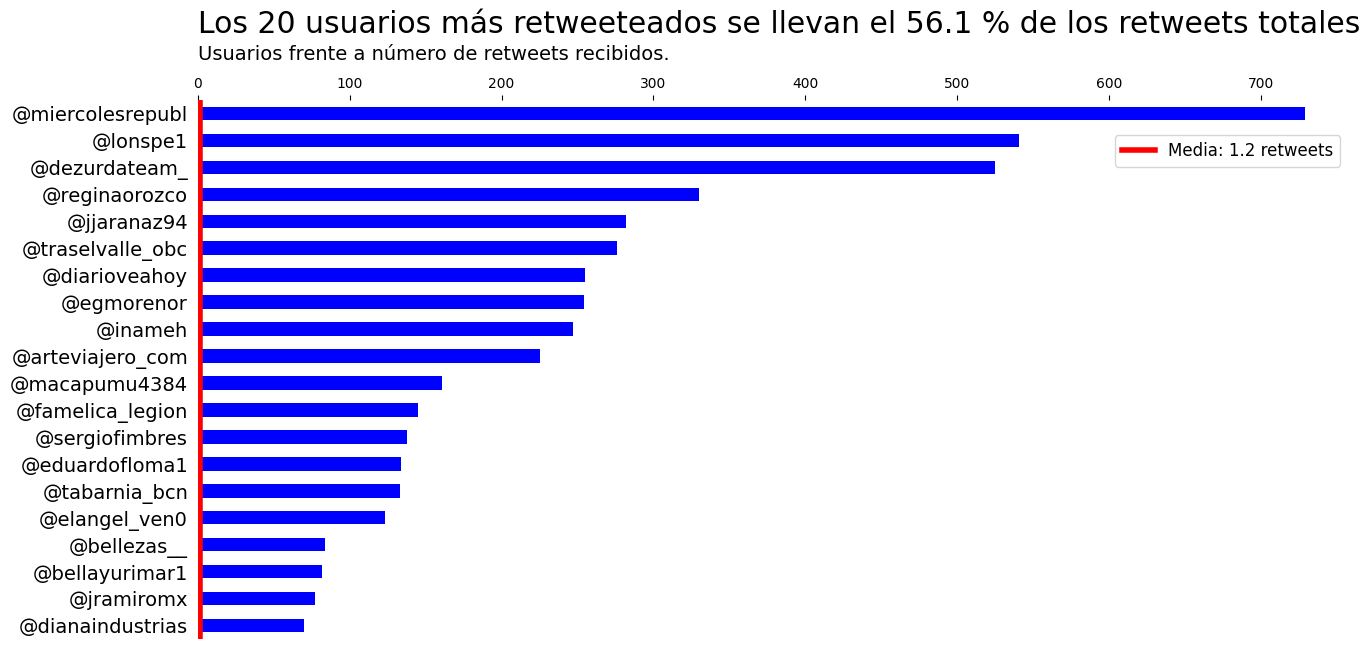

In [65]:
influencia_top20_sorted = volume.sort_values(by=['rts_received'],ascending=True).tail(20)

ax = influencia_top20_sorted.plot.barh(x='author',y='rts_received',figsize=(15,7),color='blue',label='',fontsize=14)

ax.spines[['top','bottom','left','right']].set_visible(False)
plt.tick_params(axis='x',which='both',bottom=False,top=True,labelbottom=False,labeltop=True)
plt.tick_params(axis='y',which='both',left=False,right=False)
plt.xlabel('',fontsize=14)
plt.ylabel('')
plt.text(0,22,'Los 20 usuarios más retweeteados se llevan el {} % de los retweets totales'.format(porcentaje_influencia_top20),
         fontsize=21.5)
plt.text(0,21, 'Usuarios frente a número de retweets recibidos.',fontsize=14)
plt.axvline(x=mean_rts_received,color='red',linewidth=4,label='Media: {} retweets'.format(mean_rts_received))
plt.legend(bbox_to_anchor=(0.99,0.95),prop={'size': 12})
plt.savefig('6.3 retweeteados.jpg',bbox_inches='tight',dpi=50)

### Retweets realizados

In [66]:
retweets_made_top20 = volume.sort_values(by=['rts_made'],ascending=False).head(20)
retweets_made_top20.head()

,author,total,original_tweets,true_original_tweets,rts_made,rts_received
557,@traselvalle_obc,404,3,3,401,276
2162,@jjaranaz94,157,0,0,157,282
1595,@jramiromx,132,68,32,64,77
1466,@ailaxy,26,2,2,24,46
200,@faby_nava77,27,4,3,23,33


In [67]:
porcentaje_rts_made_top20 = (retweets_made_top20['rts_made'].sum()/volume['rts_made'].sum()*100).round(1)
porcentaje_rts_made_top20

11.0

In [68]:
mean_rts_made = round(volume['rts_made'].mean(),1)
mean_rts_made

1.2

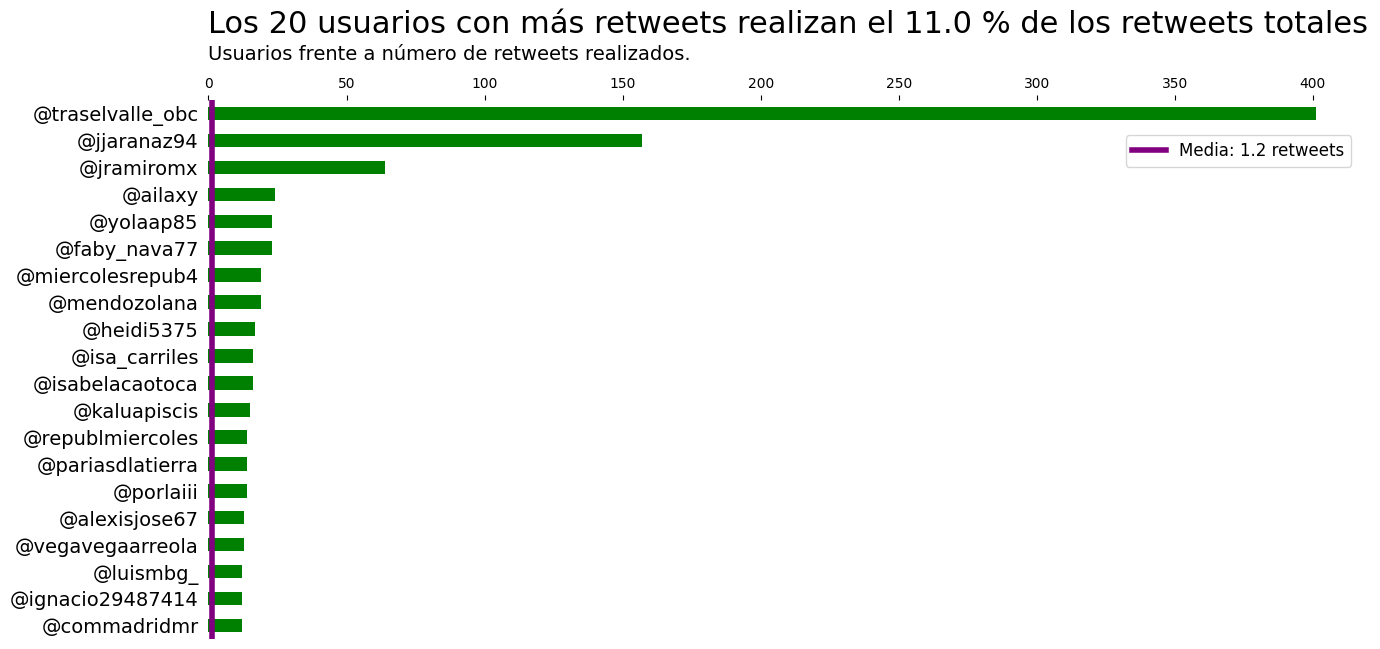

In [69]:
retweets_made_top20_sorted = volume.sort_values(by=['rts_made'],ascending=True).tail(20)

ax = retweets_made_top20_sorted.plot.barh(x='author',y='rts_made',figsize=(15,7),color='green',label='',fontsize=14)
ax.spines[['top','bottom','left','right']].set_visible(False)
plt.tick_params(axis='x',which='both',bottom=False,top=True,labelbottom=False,labeltop=True)
plt.tick_params(axis='y',which='both',left=False,right=False)
plt.xlabel('',fontsize=14)
plt.ylabel('')
plt.text(0,22,'Los 20 usuarios con más retweets realizan el {} % de los retweets totales'.format(porcentaje_rts_made_top20),
         fontsize=22)
plt.text(0,21,'Usuarios frente a número de retweets realizados.',fontsize=14)
plt.axvline(x=mean_rts_received,color='purple',linewidth=4,label='Media: {} retweets'.format(mean_rts_made))
plt.legend(bbox_to_anchor=(0.99,0.95),prop={'size': 12})
plt.savefig('6.4 rts hechos.jpg',bbox_inches='tight',dpi=50)

Representamos las 4 medidas con gráficos de tarta.

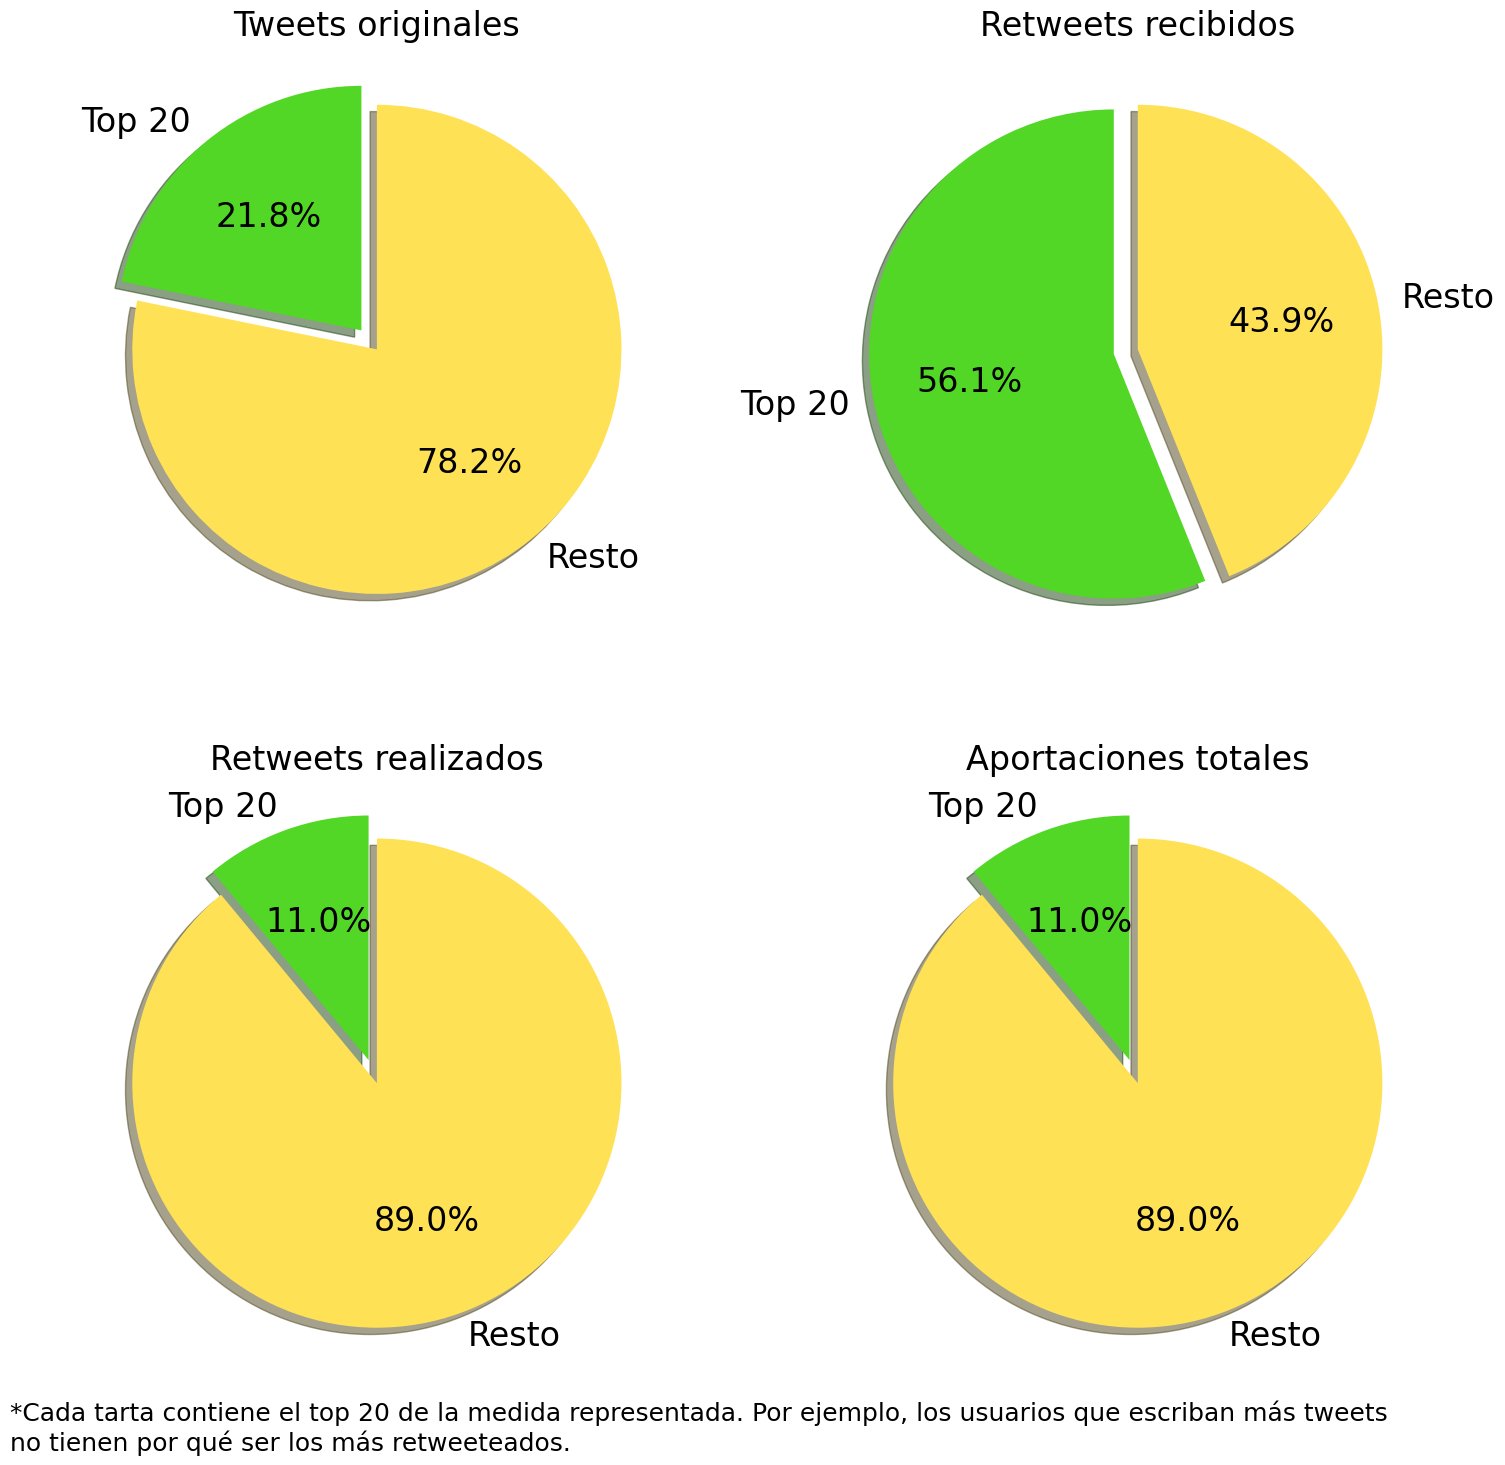

In [70]:
plt.figure(figsize=(18,27))
explode = (0.1, 0)
plt.subplot(3,2,1)
plt.pie([true_original_top20_percentage, 100-true_original_top20_percentage], explode=explode,
        labels=('Top 20', 'Resto'), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 24,'color':"black"},
       colors = ['#52D726', '#FFE156'])
plt.title('Tweets originales',fontsize=24)
plt.text(-1.5,-4.5,'*Cada tarta contiene el top 20 de la medida representada. Por ejemplo, los usuarios que escriban más tweets\nno tienen por qué ser los más retweeteados.',
         fontsize=18)


plt.subplot(3, 2, 2)
plt.pie([porcentaje_influencia_top20, 100-porcentaje_influencia_top20], explode=explode,
        labels=('Top 20', 'Resto'), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 24,'color':"black"},
       colors = ['#52D726', '#FFE156'])
plt.title('Retweets recibidos',fontsize=24)

plt.subplot(3, 2, 3)
plt.pie([porcentaje_rts_made_top20, 100-porcentaje_rts_made_top20], explode=explode,
        labels=('Top 20', 'Resto'), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 24,'color':"black"},
       colors = ['#52D726', '#FFE156'])
plt.title('Retweets realizados',fontsize=24)

plt.subplot(3, 2, 4)
plt.pie([porcentaje_aportaciones_top20, 100-porcentaje_aportaciones_top20], explode=explode,
        labels=('Top 20', 'Resto'), autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 24,'color':"black"},
       colors = ['#52D726', '#FFE156'])
plt.title('Aportaciones totales',fontsize=24)

plt.savefig('6.5 todos juntos.jpg',bbox_inches='tight',dpi=50)

### Medida de esfuerzo inventada

En relación al número de tweets y retweets, podemos desarrollar una medida del esfuerzo que conlleva escribir un tweet original. Esto es diferente para cada hashtag, pues es más difícil escribir en un hashtag político que en #felizmartes, que es un hashtag donde cualquiera podría decir algo.

La medida de esfuerzo es el número de retweets dividido entre el número de tweets originales.

In [71]:
effort_variable = volume['rts_made'].sum()/volume['true_original_tweets'].sum()
effort_variable_rounded = effort_variable.round(1)
effort_variable_rounded

3.1

In [72]:
print('Hay {} retweets por cada tweet original.'.format(effort_variable_rounded))

Hay 3.1 retweets por cada tweet original.


Tomamos el top 5 de usuarios con más participaciones y calculamos su esfuerzo para comprobar si hacen más tweets originales o retweets.

In [73]:
volume['effort'] = volume['true_original_tweets']*effort_variable - volume['rts_made']
volume_top_20 = volume.sort_values(by=['total'], ascending=False).head(20)
volume_top_20.head()

,author,total,original_tweets,true_original_tweets,rts_made,rts_received,effort
557,@traselvalle_obc,404,3,3,401,276,-391.611387
2162,@jjaranaz94,157,0,0,157,282,-157.000000
1595,@jramiromx,132,68,32,64,77,36.145204
19,@elhoroscopodel1,106,106,106,0,8,331.730990
988,@benavidesang,90,90,90,0,8,281.658387


De nuevo cuidado aquí con las coordenadas (plt.text(x,y), etc.)

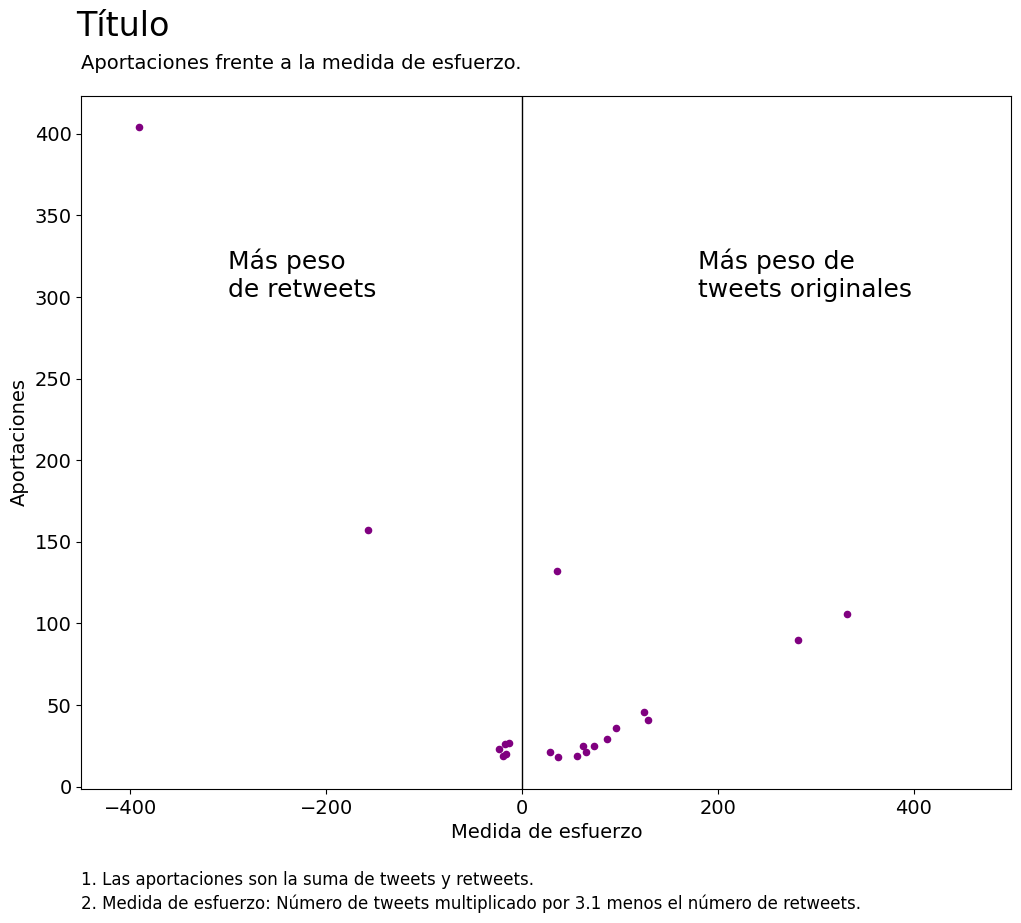

In [74]:
ax = volume_top_20.plot.scatter(x='effort',y='total',figsize=(12,9),fontsize=14,color='purple')
plt.xlabel('Medida de esfuerzo',fontsize=14)
plt.ylabel('Aportaciones',fontsize=14)
plt.text(-455,460,'Título',fontsize=24)
plt.text(-450,440,'Aportaciones frente a la medida de esfuerzo.',fontsize=14)
plt.text(-450,-60,'1. Las aportaciones son la suma de tweets y retweets.',fontsize=12)
plt.text(-450,-75,'2. Medida de esfuerzo: Número de tweets multiplicado por {} menos el número de retweets.'.format(effort_variable_rounded),
         fontsize=12)
plt.axvline(x=0,color='black',linewidth=1)
plt.xlim(-450,500)
plt.text(-300,300,'Más peso\nde retweets',fontsize=18)
plt.text(180,300,'Más peso de\ntweets originales',fontsize=18)
plt.savefig('8. medida de esfuerzo.jpg',bbox_inches='tight',dpi=100)

### Porcentaje de tweets originales contra porcentaje de retweets.

In [75]:
original_percentage = (volume['true_original_tweets'].sum()/volume['total'].sum()*100).round(1)
rt_percentage = ((volume['rts_made'].sum()+copied_tweets)/volume['total'].sum()*100).round(1)
print(original_percentage,rt_percentage)

23.7 76.3


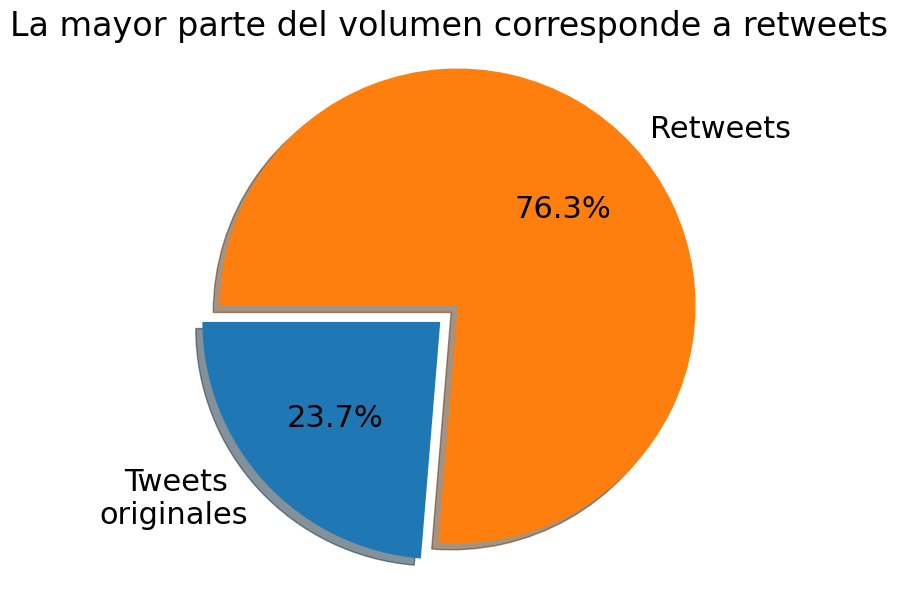

In [76]:
labels = 'Tweets  \noriginales', 'Retweets'
sizes = [original_percentage, rt_percentage]
explode = (0.1, 0)
fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=180, textprops={'fontsize': 22})
ax1.axis('equal')
plt.title('La mayor parte del volumen corresponde a retweets',fontsize=24)
plt.savefig('9.porcentaje de tweets y retweets.jpg',bbox_inches='tight',dpi=50)

## Buscar palabras

Vamos a filtrar el pico por los tweets que contengan ciertas palabras.

In [77]:
lista_palabras = ['amor','viernes','amigo','dias','buenos']

In [78]:
ht_palabra = ht_pico[ht_pico['text'].str.contains('|'.join(lista_palabras))]
ht_palabra = ht_palabra[['id tweet','author','text']]
ht_palabra = ht_palabra.drop_duplicates(subset='text',keep='first')
ht_palabra = ht_palabra[~ht_palabra['text'].str.startswith('rt @')]
print('Hay',len(ht_palabra),'con las palabras seleccionadas.')
ht_palabra.head(10)

Hay 538 con las palabras seleccionadas.


,id tweet,author,text
2,1567097699824017411,@gichineando,"#buenosdias #buenosdiasatodos #buenosdiasatodxs #felizmartesatodos #felizmartes #martesdeganarseguidores ando, ando, madrugando ¿y tú?"
4,1567097742194769926,@abe32555420,@daragino8022 buenos dias salah #felizmartes 😘😘😘🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄
7,1567097764592422912,@nelvaldez,¡buenos días! #felizmartes con mucha actitud para todos 😎✌️
10,1567097780732153856,@listindiario,"#fraselistín | buenos días, lectores. #felizmartes #lovivimosconellistín #listíndiario https://t.co/pxmwfdlkgr"
15,1567097862940508160,@catalanpedros,sentencias ⚖️ condenado a pagar el alquiler pese a no vivir en la casa por una orden de alejamiento. vía @cincodiascom ➡️https://t.co/9d1mbwt0fc #abogados #valencia #felizmartes #derecho #sentencias https://t.co/1dex8ubgv2
21,1567097913431715841,@vanenu31,#buenosdiasatodos tropas 🇲🇽💚 #felizmartes #ejercitomexicano #guardianacional #felizdiadelinformatico https://t.co/jbokh97v9s
24,1567097938672852994,@abe32555420,@luisrod50159073 buenos dias luis #felizmartes 😘😘😘🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄🍄
27,1567098016829423617,@tenerifeliz,"muy #buenosdías y #felizmartes. así de espectacular, está la mañana en la #playadelasvistas (@aytoarona) a las 11:20. have a nice day! - #tenerife #teneriffa #тенерифе #tuesdayvibe #tuesdaymotivatons - #6deseptiembre - #tenerifeliz. https://t.co/9uca2kofvb"
31,1567098120474968064,@misionpaz_,"los seres humanos conocemos el amor, pero no un amor puro, desinteresado y honesto como el que dios tiene por nosotros. ☺️👏 lee el devocional aquí: 🌟https://t.co/6zoe0ydoms #life #reflexion #felizmartes https://t.co/ez48jfzifk"
32,1567098133435260936,@tribunavigila,"🌞 ¡buenos días! si viajas a la #cdmx recuerda que el programa #hoynocircula aplica este #felizmartes para vehículos con #engomadorosa, terminación de placas 7 y 8, holograma 1 y 2. 🚕🚗🚘🚙🚛 https://t.co/8e9pc4em1j"
